In [1]:
#| default_exp inside_outside_laziness

In [2]:
# from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

In [4]:
#| export
from tqdm.notebook import trange
def inside_outside_laziness(A, diffusion_powers = 8, aperture = 80, neighborhood = 1, dynamically_adjusting_neighborhood = False, smoothing=1, verbose=True, proportion_inside = 4):
    """Take a localized measure of diffusion laziness, with diffusion restricted to with the given aperture. Estimates curvature.

    Parameters
    ----------
    A : ndarray
        Affinity matrix of data (non-row normalized)
    diffusion_powers : int, optional
        The number of matrix powers to raise the diffusion operature, by default 8
    aperture : int, optional
        The number of nearest neighbors to which to limit the diffusion operator, by default 80
    neighborhood : int, optional
        The number of nearest neighbors of a point to use calculating laziness, by default 1
    dynamically_adjusting_neighborhood : bool, optional
        Whether the aperture and neighborhood should be based on thresholds derived over the dataset (False) or 
        should expand to create the designated number of neighbors everywhere in the dataset (if True), by default False
    smoothing : int, optional
        Number of iterations of diffusion averaging to apply to the laziness values before returning, by default 1
    verbose : bool, optional
        Whether to print debugging statements and return extra debugging information, by default True

    Returns
    -------
    list
        Laziness value at each point
    """
    # First, a proof of concept: iterate through every point,
    # Make a sub-diffusion matrix for that point, consisting only of the k neighborhood
    # And calculate the laziness for each value
    ks = []
    # debugging
    inside_measures = []
    outside_measures = []
    list_of_Ps = []
    list_of_idxs = []
    # TODO: This is not very efficient; it fails to reuse the computations in each diffusion matrix, 
    # since each point has a separate matrix. Must reconsider that.
    for i in trange(A.shape[0]):
        # Get the indices of the "aperture" closest points, as measured by the diffusion probabilities
        idxs = np.argsort(A[i])[-aperture:][::-1] # ordered from greatest to least affinity
        # Create a sub-diffusion matrix. The point i should be first, since the unpowered matrix
        # measures affinity
        W_sub = A[idxs][:,idxs]
        degrees = np.diag(1/np.sum(W_sub,axis=1))
        P = degrees @ W_sub
    
        # Create the thresholded P, where the threshold is given by the affinity
        # between point i and the halfway point
        threshold = P[0,aperture//proportion_inside]
        P_thresholded = (P >= threshold).astype(int)

        P_powered = np.linalg.matrix_power(P,diffusion_powers)
        inside_matrix = P_powered * P_thresholded
        inside_measure = np.sum(inside_matrix[0])
        
        outside_matrix = P_powered * np.abs(1 - P_thresholded)
        outside_measure = np.sum(outside_matrix[0])
        
        expected_inside_measure = inside_measure / np.sum(P_thresholded[0])
        expected_outside_measure = outside_measure / (len(P_thresholded) - np.sum(P_thresholded[0]))
        
        k = expected_inside_measure - expected_outside_measure
        ks.append(k)
        list_of_Ps.append(P_powered)
        list_of_idxs.append(idxs)
        inside_measures.append(expected_inside_measure)
        outside_measures.append(expected_outside_measure)
    # Smoothing
    if smoothing is not None:  
        D = np.diag(1/np.sum(A,axis=1))
        P = D @ A 
        P_t = np.linalg.matrix_power(P,smoothing)
        ks_smoothed = P_t @ np.array(ks)[:,None]
        ks = ks_smoothed.squeeze()
        inside_measures = (P_t @ np.array(inside_measures)[:,None]).squeeze()
        outside_measures = (P_t @ np.array(outside_measures)[:,None]).squeeze()
        ks_smoothy = inside_measures - outside_measures
    if verbose:
        return ks_smoothy, inside_measures, outside_measures, list_of_Ps, list_of_idxs
    return ks


With the code written, let's test it on our old friend, the torus

In [5]:
import diffusion_curvature

In [6]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import diffusion_matrix, plot_3d, gaussian_kernel
X, ks = torus(n=5000, use_guide_points=True)

In [7]:
A = gaussian_kernel(X,kernel_type="adaptive anisotropic",k=20)

ValueError: 'c' argument has 2564 elements, which is inconsistent with 'x' and 'y' with size 2567.

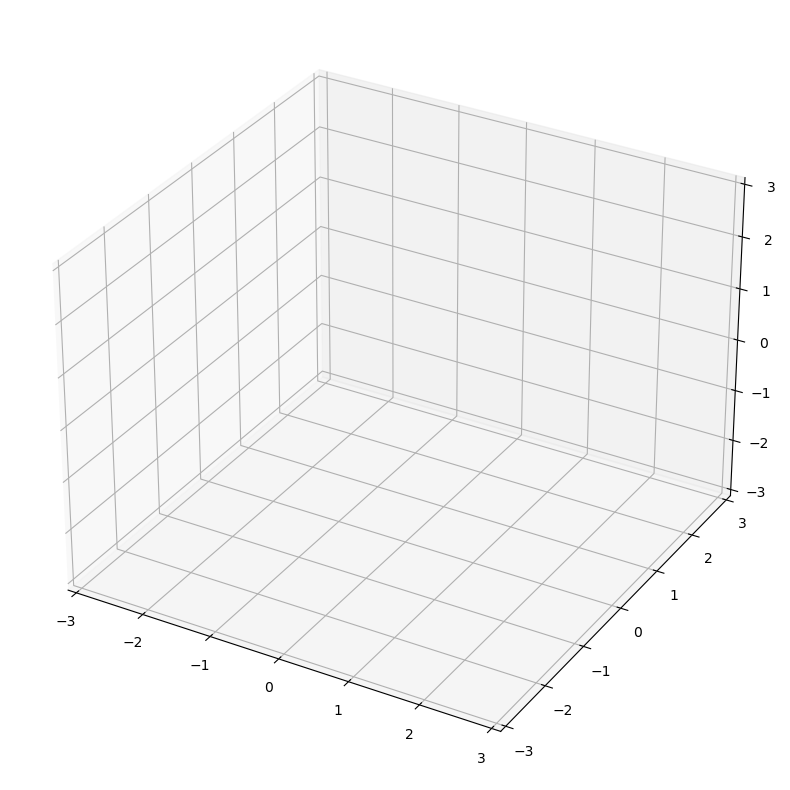

In [8]:
plot_3d(X, ks)

## Testing the method

In [ ]:
aperture = 50
diffusion_powers = 32
neighborhood=2
smoothed = 1
proportion_inside = 3
ks, inside_measures, outside_measures, Ps, idxs = inside_outside_laziness(A, 
                                                                          diffusion_powers=diffusion_powers, 
                                                                          aperture=aperture, 
                                                                          neighborhood=neighborhood,
                                                                          smoothing=smoothed, 
                                                                          proportion_inside=proportion_inside)



  0%|          | 0/2540 [00:00<?, ?it/s]

In [ ]:
min(ks)

0.0056836000432738225

In [ ]:
min(inside_measures)

0.023716593385205723

In [ ]:
max(outside_measures)

0.018065778967056016

Let's see what the aperture looked like

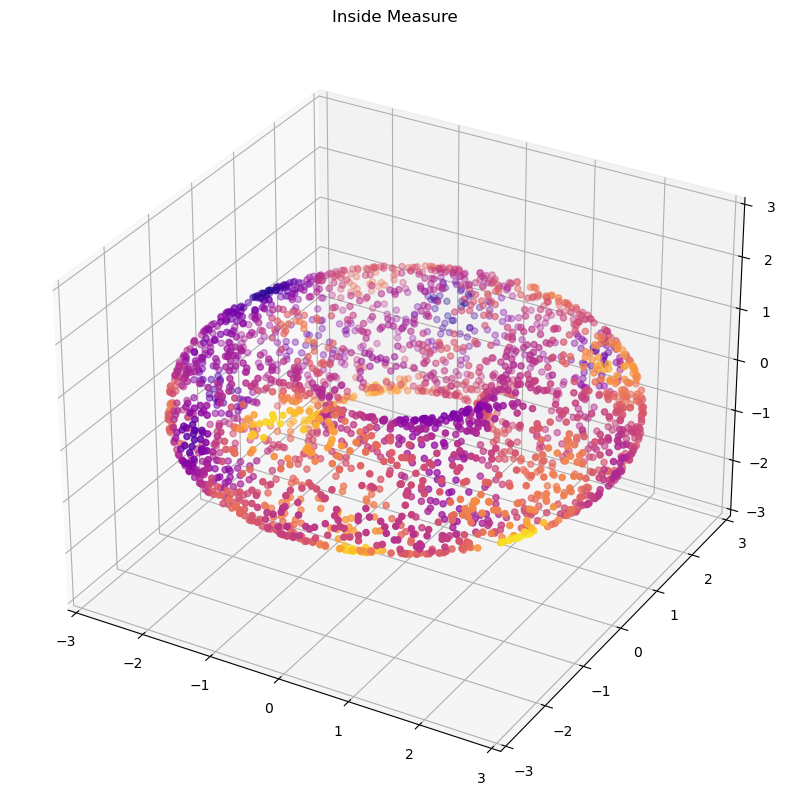

In [ ]:
plot_3d(X,distribution=inside_measures,title="Inside Measure",use_plotly=False)


What does a diffusion look like?

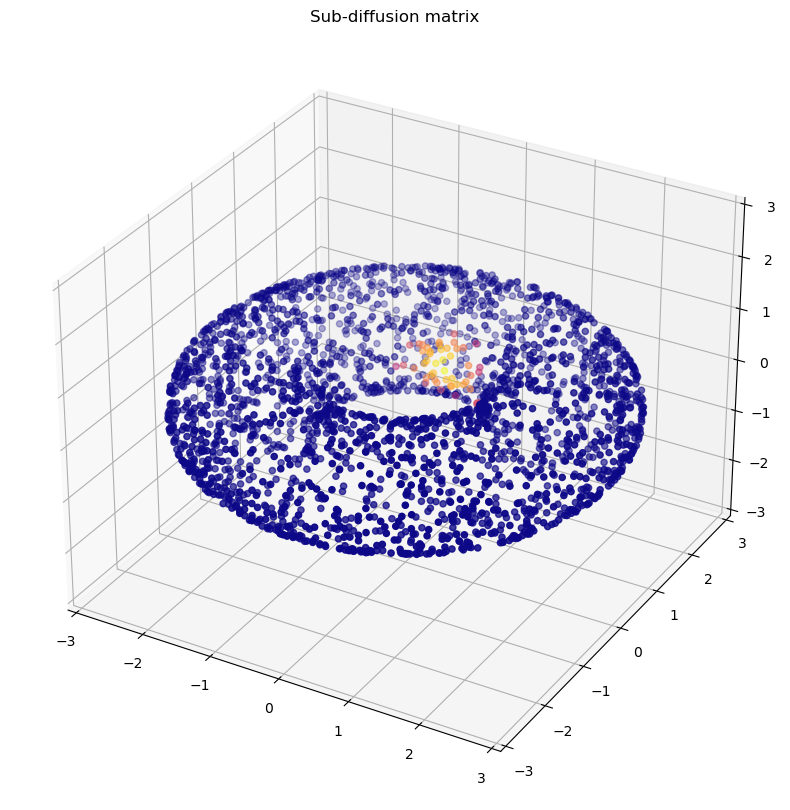

In [ ]:
p = 1
diff_vals = Ps[p][0]
dist = np.zeros(len(X))
for i in range(len(idxs[p])):
    dist[idxs[p][i]] = diff_vals[i]
plot_3d(X,distribution=dist,title="Sub-diffusion matrix")

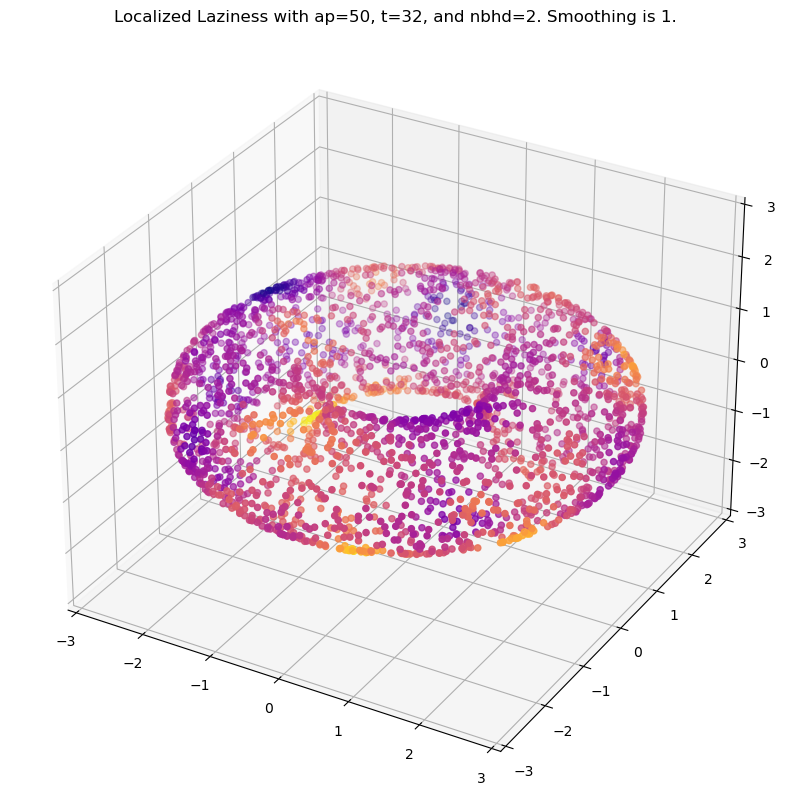

In [ ]:
plot_3d(X,ks,title = f"Localized Laziness with ap={aperture}, t={diffusion_powers}, and nbhd={neighborhood}. Smoothing is {smoothed}.")

# Validation with Distribution Plots

In [ ]:
import matplotlib.pyplot as plt

What are the distributions of laziness values in three parts of the torus?

For a positively curved region, we expect the mass to remain clumped in the middle, hence there should be a smaller number of larger points.

Text(0.5, 1.0, '+ Curvature')

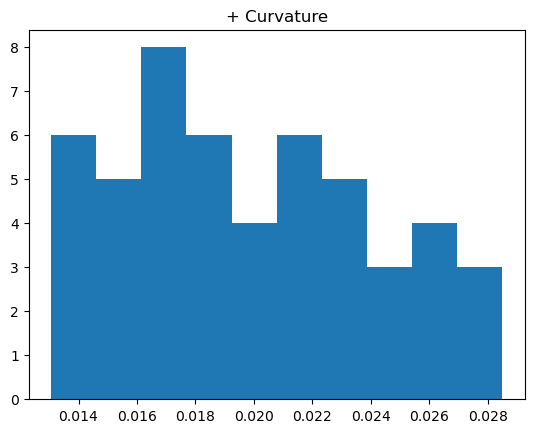

In [ ]:
p = 0
dist = Ps[p][0]
plt.hist(dist)
plt.title("+ Curvature")

For a region of little curvature, we expect a more even spread.

Text(0.5, 1.0, '0 Curvature')

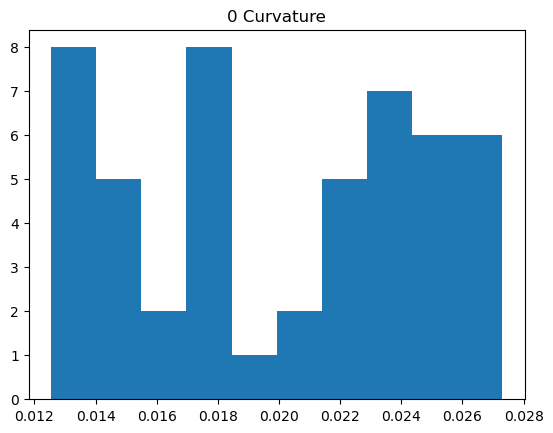

In [ ]:
p = 2
dist = Ps[p][0]
plt.hist(dist)
plt.title("0 Curvature")

For a region of negative curvature, we expect the mass to be pushed to the sides, creating a greater number of not-quite-as-large points.

Text(0.5, 1.0, '- Curvature')

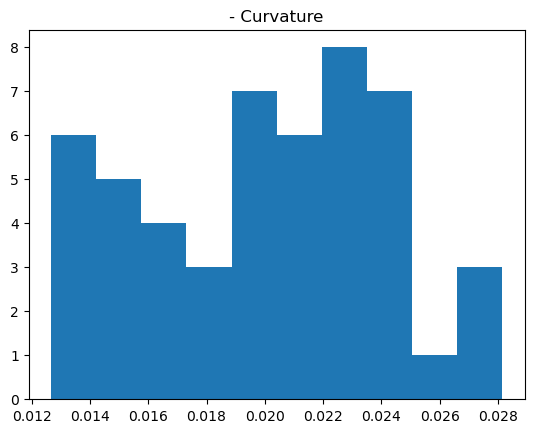

In [ ]:
p = 1
dist = Ps[p][0]
plt.hist(dist)
plt.title("- Curvature")

# V2

In [ ]:
#| export
import numpy as np
def inside_outside_laziness_v2(P, diffusion_powers=8, inner_aperture = 20, outer_aperture = 40, smoothing=1, verbose = False, dynamically_adjusting_neighborhood = False, precomputed_powered_P = None, non_lazy_diffusion=False, restrict_diffusion_to_k_neighborhood=None, use_min_threshold = False):
    """Diffusion Laziness Curvature
    Estimates curvature by measuring the amount of mass remaining within an initial neighborhood after t steps of diffusion. Akin to measuring the laziness of a random walk after t steps.

    Parameters
    ----------
    P : n x n ndarray
        The diffusion matrix of the graph
    diffusion_powers : int, optional
        Number of steps of diffusion to take before measuring the laziness, by default 8
    aperture : int, optional
        The size of the initial neighborhood, from which the percentage of mass remaining in this neighborhood is calculated, by default 20
    smoothing : int, optional
        Amount of smoothing to apply. Currently works by multiplying the raw laziness values with the diffusion operator, as a kind of iterated weighted averaging; by default 1
    verbose : bool, optional
        Print diagnostics, by default False
    return_density : bool, optional
        Return the number of neighbors each point shares, by default False
    dynamically_adjusting_neighborhood : bool, optional
        Whether to give each point the same initial neighborhood size, by default False
    precomputed_powered_P : ndarray, optional
        Optionally pass a precomputed powered diffusion operator, to speed up computation, by default None
    avg_transition_probability: bool, default True
        Use the definition of diffusion curvature in which the summed transition probabilities are divided by the total number of points in the aperture neighborhood.
        As a result, gives not the summed "return probability within the neighborhood" but the average return probability to each point in the aperture neighborhood.
        This formulation of diffusion curvature was used in proof given in our NeurIPS 2022 paper.

    Returns
    -------
    length n array
        The laziness curvature values for each point
    """
    # the aperture sets the size of the one-hop neighborhood 
    # the aperture parameter is the average number of neighbors to include, based off of the sorted diffusion values
    # Set thresholds as the kth largest diffusion value, presumed to be held by the kth nearest neighbor.
    # The curvature donut: an inner hole and an outer hole. The inner aperture determines
    # the size of the inner hole
    # The outer threshold determines the size of the outer hole
    inner_thresholds = np.partition(P,-inner_aperture)[:,-inner_aperture]
    outer_thresholds = np.partition(P,-outer_aperture)[:,-outer_aperture]
    P_threshold_inner = np.mean(inner_thresholds) 
    P_thresholded_inner = (P >= P_threshold_inner).astype(int)
    
    P_threshold_outer = np.mean(outer_thresholds) 
    P_thresholded_outer = (P >= P_threshold_outer).astype(int) - P_thresholded_inner
    
    if precomputed_powered_P is not None:
        P_powered = precomputed_powered_P
    else:
        P_powered = np.linalg.matrix_power(P,diffusion_powers)
    
    # take the diffusion probs of the neighborhood
    inside_laziness = np.sum(P_powered * P_thresholded_inner,axis=1)    
    local_density = np.sum(P_thresholded_inner,axis=1)
    # divide by the number of neighbors diffused to
    local_density[local_density==0]=1
    expected_inside_laziness = inside_laziness / local_density
    # repeat for outside laziness
    outside_laziness = np.sum(P_powered * P_thresholded_outer,axis=1)    
    local_density = np.sum(P_thresholded_outer,axis=1)
    # divide by the number of neighbors diffused to
    local_density[local_density==0]=1
    expected_outside_laziness = outside_laziness / local_density
    
#     ks = expected_inside_laziness - expected_outside_laziness
    
    if smoothing: # TODO there are probably more intelligent ways to do this smoothing
        # Local averaging to counter the effects local density
        if verbose: print("Applying smoothing...")
        smoothing_P_powered = np.linalg.matrix_power(P,smoothing)
        expected_inside_laziness = (smoothing_P_powered @ expected_inside_laziness[:,None]).squeeze()
        expected_outside_laziness = (smoothing_P_powered @ expected_outside_laziness[:,None]).squeeze()
        ks = expected_inside_laziness - expected_outside_laziness
    return ks, expected_inside_laziness, expected_outside_laziness


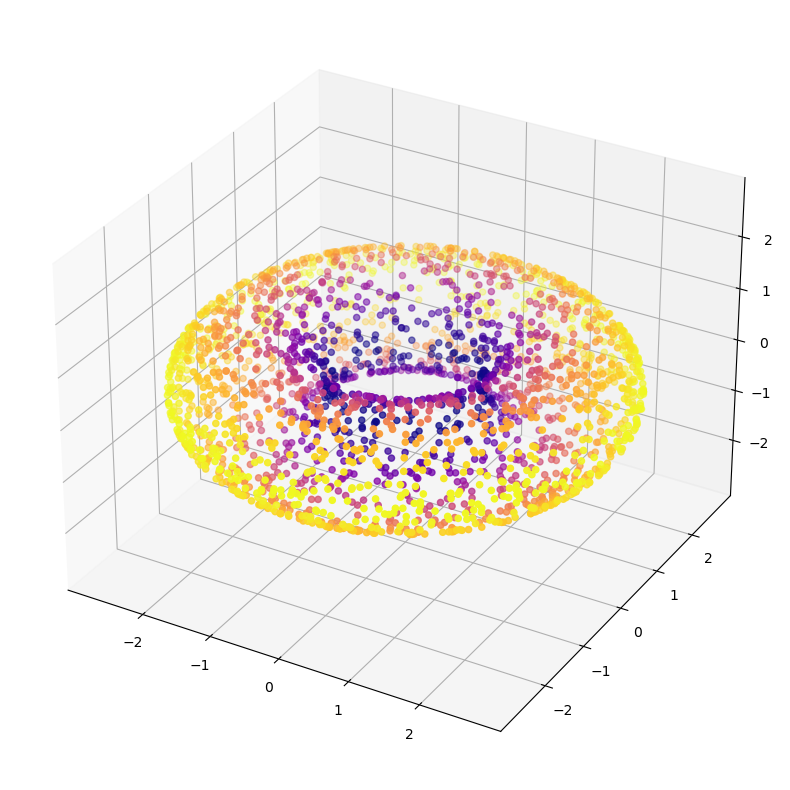

In [ ]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import diffusion_matrix, plot_3d
X, ks_true = torus(n=5000, use_guide_points=False)
P = diffusion_matrix(X,kernel_type="adaptive",k=20)
plot_3d(X,ks_true)

In [ ]:
ks, iks, oks = inside_outside_laziness_v2(
    P,
    diffusion_powers = 16,
    inner_aperture = 10,
    outer_aperture = 20
)

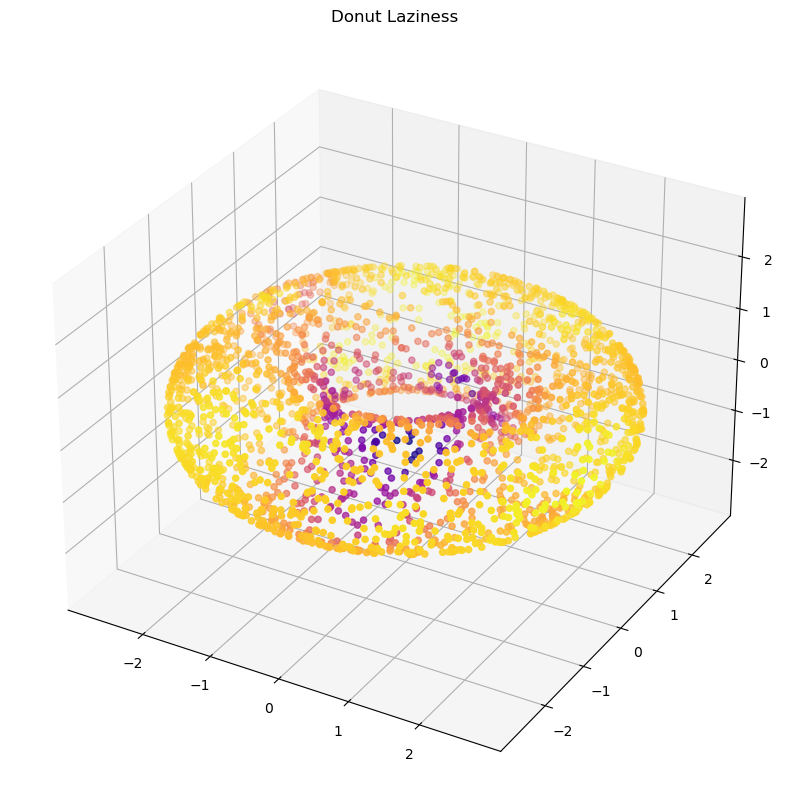

In [ ]:
plot_3d(X,ks, title=f"Donut Laziness")

In [ ]:
print(f"min {min(ks)} max {max(ks)}")

min -7.17312192102873e-05 max 3.252734065550562e-05


In [ ]:
min(ks_true)

-1.999999949625309

In [ ]:
max(ks_true)

1.333332986076776

In [ ]:
1.333/-1.999

-0.6668334167083542

In [ ]:
3.35/-5.74

-0.5836236933797909